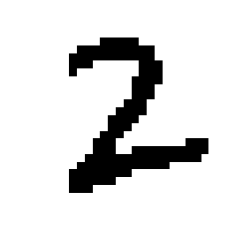

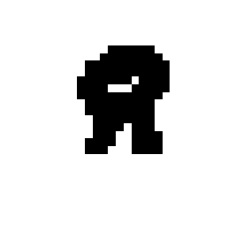

CPU times: user 9.84 ms, sys: 174 µs, total: 10 ms
Wall time: 10 ms
CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.86 s


In [3]:
%run ../functions.ipynb ;

In [58]:
def computepsiprime(mps, img, contracted_left_index):
    '''
    Contract the MPS with the states (pixels) of a binary{0,1} image
    
    PSI':    O-...-O-      -O-...-O
             |     |        |     |
             |     |  |  |  |     |
    IMAGE:   O     O  O  O  O     O
    
    Images state are created the following way:
    if pixel is 0 -> state = [0,1]
    if pixel is 1 -> state = [1,0]
    '''
    
    #############
    # LEFT PART #
    #############
    
    # Left most tensor
    #          O--
    # Compute  |  => O--
    #          O
    if img[0] == 0:
        contraction_sx = np.einsum('a,ba',[0,1], mps.tensors[0].data)
    else:
        contraction_sx = np.einsum('a,ba',[1,0], mps.tensors[0].data)
        
    for k in range(1, contracted_left_index):
        #  
        # Compute  O--O--  => O--
        #             |       |
        contraction_sx = np.einsum('a,abc->bc',contraction_sx, mps.tensors[k].data)
        
        #          O--
        # Compute  |  => O--
        #          O        
        if img[k] == 0:
            contraction_sx = np.einsum('a,ba', [0,1], contraction_sx)
        else:
            contraction_sx = np.einsum('a,ba', [1,0], contraction_sx)
    
    ##############
    # RIGHT PART #
    ##############
    
    # Right most tensor
    #          ---O
    # Compute     |  => --O
    #             O
    if img[-1] == 0:
        contraction_dx = np.einsum('a,ba',[0,1], mps.tensors[-1].data)
    else:
        contraction_dx = np.einsum('a,ba',[1,0], mps.tensors[-1].data)
        
    for k in range(len(mps.tensors)-2, contracted_left_index+2, -1): # CHECK THE BOUNDS
        #  
        # Compute  --O--O  => --O
        #               |       |
        
        contraction_dx = np.einsum('a,bac->bc',contraction_dx, mps.tensors[k].data)
        
        #          --O
        # Compute    |  => --O
        #            O        
        if img[k] == 0:
            contraction_dx = np.einsum('a,ba', [0,1], contraction_dx)
        else:
            contraction_dx = np.einsum('a,ba', [1,0], contraction_dx)
    
    # From here on it is just speculation
    
    if img[contracted_left_index] == 0:
        contraction_sx = np.einsum('a,k->ak', contraction_sx, [0,1])
    else:
        contraction_sx = np.einsum('a,k->ak', contraction_sx, [1,0])
        
    if img[contracted_left_index+1] == 0:
        contraction_dx = np.einsum('a,k->ak', contraction_dx, [0,1])
    else:
        contraction_dx = np.einsum('a,k->ak', contraction_dx, [1,0])
    
    contraction = np.einsum('ab,cd->abcd', contraction_sx, contraction_dx)
    
    return contraction

In [47]:
def learning_step(mps, index, imgs, lr):
    
    Z = mps @ mps
    A = (mps.tensors[index] @ mps.tensors[index+1])
    print('######################\nSTEP: {}'.format(index) )
    print('A: {}'.format(A.data.shape) )
    
    psifrac = 0
    for img in imgs:
        num = computepsiprime(mps,img,index)
        den = computepsi(mps,img)
        
        psifrac = psifrac + num/den
    
    psifrac = psifrac/imgs.shape[0]
    
    print('A\': {}'.format(A.data.shape) )
    print('psiprime: {}\n'.format(psifrac.shape) )
    dNLL = (A/Z) - psifrac
    
    A = A + lr*dNLL
    
    SD = A.split(['i'+str(index-1),'v'+str(index)], absorb='right')
    
    return SD

In [59]:
mps = initialize_mps(bdim=30)

In [60]:
imgs = train_set[:10]

In [61]:
progress = tqdm(range(1,len(mps.tensors)-2))

  0%|                                                   | 0/781 [00:00<?, ?it/s]

In [ ]:
for index in progress:
    A = learning_step(mps,index,imgs,0.08)
    
    mps.tensors[index].modify(data=np.transpose(A.tensors[0].data,(0,2,1)))
    mps.tensors[index+1].modify(data=A.tensors[1].data)
    
    p0 = computepsi(mps,imgs[0])**2
    progress.set_description('P(0) = {}'.format(p0))

In [63]:
computepsi(mps,imgs[0])**2

0.002094112856590995

In [64]:
computepsi(mps,np.random.randint(0,2,(784)) )**2

2.2365996628196876e-246